In [4]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
#os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/opt/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.9-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [19]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory" ,"32G") \
    .getOrCreate()

spark

NameError: name 'SparkSession' is not defined

## Load the [Wine Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine)

In [20]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data

In [21]:
import pandas as pd
df = pd.DataFrame(X, columns=wine.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## Create a Spark DataFrame

In [22]:
df = spark.createDataFrame(df)

In [23]:
df.show(5)

+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|od280/od315_of_diluted_wines|proline|
+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|  14.23|      1.71|2.43|             15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92| 1065.0|
|   13.2|      1.78|2.14|             11.2|    100.0|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|                         3.4| 1050.0|
|  13.16|      2.36|2.67|             18.6|    101.0|          2.8|      3.24|                 0.3|           2.81|           5.68

In [60]:
df.printSchema()

root
 |-- alcohol: double (nullable = true)
 |-- malic_acid: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcalinity_of_ash: double (nullable = true)
 |-- magnesium: double (nullable = true)
 |-- total_phenols: double (nullable = true)
 |-- flavanoids: double (nullable = true)
 |-- nonflavanoid_phenols: double (nullable = true)
 |-- proanthocyanins: double (nullable = true)
 |-- color_intensity: double (nullable = true)
 |-- hue: double (nullable = true)
 |-- od280/od315_of_diluted_wines: double (nullable = true)
 |-- proline: double (nullable = true)
 |-- features2: vector (nullable = true)



### Normalize the dataset

In [62]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols = df.columns, outputCol='features')
scaler = StandardScaler(inputCol = 'features', outputCol = 'normFeatures', withMean = True)

df = assembler.transform(df)
scalarModel = scaler.fit(df)
df = scalarModel.transform(df)

In [64]:
df.printSchema()

root
 |-- alcohol: double (nullable = true)
 |-- malic_acid: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcalinity_of_ash: double (nullable = true)
 |-- magnesium: double (nullable = true)
 |-- total_phenols: double (nullable = true)
 |-- flavanoids: double (nullable = true)
 |-- nonflavanoid_phenols: double (nullable = true)
 |-- proanthocyanins: double (nullable = true)
 |-- color_intensity: double (nullable = true)
 |-- hue: double (nullable = true)
 |-- od280/od315_of_diluted_wines: double (nullable = true)
 |-- proline: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- normFeatures: vector (nullable = true)



## Get the RDD

In [65]:
rdd = df.select('normFeatures').rdd

## Convert the RDD into a [`RowMatrix`](https://spark.apache.org/docs/2.2.0/api/java/org/apache/spark/mllib/linalg/distributed/RowMatrix.html)

In [66]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors

In [67]:
vectors = rdd.map(Vectors.dense)
matrix = RowMatrix(vectors)

## Get the PCs of the matrix

In [69]:
pc = matrix.computePrincipalComponents(2)

In [70]:
pc

DenseMatrix(13, 2, [-0.1443, 0.2452, 0.0021, 0.2393, -0.142, -0.3947, -0.4229, 0.2985, ..., -0.065, 0.0034, -0.0288, -0.0393, -0.53, 0.2792, 0.1645, -0.3649], 0)

In [71]:
matrix_reduced = matrix.multiply(pc)

In [72]:
matrix_reduced.numCols()

2

In [73]:
import numpy as np
x_red = np.array(matrix_reduced.rows.collect())

In [74]:
x_red[1]

array([-2.20324981,  0.33245507])

In [75]:
import matplotlib.pyplot as plt

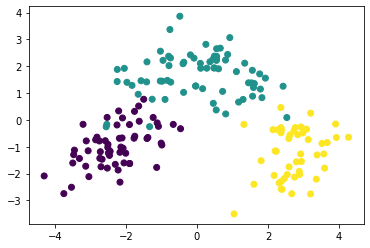

In [76]:
plt.scatter(x_red[:,0],x_red[:,1], c=wine.target)

## Verify with sklearn

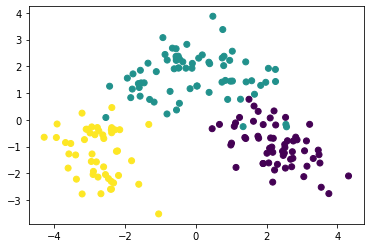

In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(wine.data)
pca = PCA()
x_red = pca.fit_transform(X)
plt.scatter(x_red[:,0],x_red[:,1], c= wine.target)

## Question: Why the difference in the scatter plots?
### (Hint: Look at the limits of the axes)